<a href="https://colab.research.google.com/github/ferdouszislam/Bangla-Handwritting-Aesthetics-Prediction-ML/blob/main/experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io

In [2]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# extract the zip file containing our dataset
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BanglaLekha-Isolated_aesthetics_dataset/prepared-datasets.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# custom dataset class
class BanglaAestheticsDataset(Dataset):
  def __init__(self, labels_csv_file, img_dir, transform=None):
    self.labels_df = pd.read_csv(labels_csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.labels_df.iloc[index, 0])
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    y_label = torch.tensor(int(self.labels_df.iloc[index, 3]))
    
    return (image, y_label)

In [6]:
# load data

# resize to same shape and convert to tensor
custom_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((50, 50)), transforms.ToTensor()])

train_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_train.csv', 
                                        img_dir='/tmp/prepared-datasets/train_images', transform=custom_transform)

val_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_val.csv', 
                                        img_dir='/tmp/prepared-datasets/validation_images', transform=custom_transform)

test_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_test.csv', 
                                        img_dir='/tmp/prepared-datasets/test_images', transform=custom_transform)

In [7]:
# data loaders

batch_size = 64 # no of samples in a single batch

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input - torch.Size([64, 1, 50, 50]) 
output - torch.Size([64])


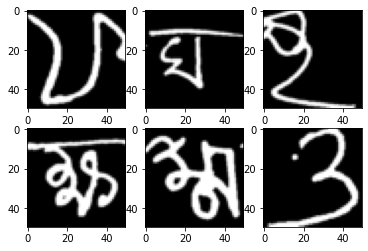

In [8]:
# visualize data
examples = iter(train_loader)
example_data, example_targets = examples.next()
print('input -', example_data.shape, '\noutput -', example_targets.shape)
# plot datatset images
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# ANN experimentation starts from here

In [9]:
# ann hyperparameters
input_size = 50*50
fc1_size = 512
fc2_size = 128
num_epochs = 100
learning_rate = 0.001

In [10]:
# custom ANN class with two hidden layers, relu activation and dropout
class ANN(nn.Module):
  def __init__(self, input_size, fc1_size, fc2_size):
    super(ANN, self).__init__()
    self.fc1 = nn.Linear(input_size, fc1_size)
    self.dropout_fc1 = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout_fc2 = nn.Dropout(0.25)
    self.output_layer = nn.Linear(fc2_size, 1)

  def forward(self, input):
    # input layer to hidden layer 1
    output = self.dropout_fc1(self.fc1(input))
    output = self.relu(output)
    # hidden layer 1 to hidden layer 2
    output = self.dropout_fc2(self.fc2(output))
    output = self.relu(output)
    # hidden layer 2 to output
    output = self.output_layer(output)
    pred = torch.sigmoid(output) # probability prediction
    return pred

In [ ]:
# cnn hyperparameters

In [ ]:
# custom cnn class 

In [11]:
PATH_TO_ANN_MODEL = 'ann_model.pth'
PATH_TO_CNN_MODEL = 'cnn_model.pth'

# training loop
def train(model, optimizer, criterion, train_loader, num_epochs, SAVE_PATH):
  min_valid_loss = np.inf
  total_train_step = len(train_loader)
  
  # train loop
  for epoch in range(num_epochs):
    train_loss = 0.0
    model.train() # set the model in train mode
    for step, (images, labels) in enumerate(train_loader):
      images = images.reshape(-1, 50*50) # flatten image
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accumulate training loss
      train_loss+=loss.item()

    valid_loss = 0.0
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
      for step, (images, labels) in enumerate(val_loader):
        images = images.reshape(-1, 50*50) # flatten image
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()

        loss = criterion(outputs, labels)

        # accumulate validation loss
        valid_loss+=loss.item()

    train_loss /= len(train_loader)
    valid_loss /= len(val_loader)
    print(f'epoch {epoch+1} --- training loss: {train_loss:.4f} --- validation loss: {valid_loss:.4f}')

    if min_valid_loss > valid_loss:
        print(f'validation loss decreased({min_valid_loss:.4f}--->{valid_loss:.4f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        #torch.save(model, 'saved_model.pth')
        model.to(device)
        torch.save(model.state_dict(), SAVE_PATH)

# evaluation 
def eval(model, test_loader):
  model.eval()
  with torch.no_grad():
    n_correct_samples = 0
    n_total_samples = 0
    for imgs, labels in test_loader:
      imgs = imgs.reshape(-1, 50*50).to(device)
      labels = labels.to(device).reshape(-1, 1)

      outputs = model(imgs)

      #pred = outputs.round() # if outputs>=0.5 class = 1, else class = 0
      pred = torch.round(outputs)

      #print(pred.shape, labels.shape)
      
      n_total_samples+=labels.size(0)
      n_correct_samples+=pred.eq(labels).sum().item()

    print(f'Accuracy = {100*n_correct_samples/n_total_samples : 0.3f}')

In [12]:
# init model
model = ANN(input_size=input_size, fc1_size=fc1_size, fc2_size=fc2_size)
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, optimizer, criterion, train_loader, num_epochs=15)

epoch 1 --- training loss: 0.6585 --- validation loss: 0.6290
validation loss decreased(inf--->0.6290) 	 Saving The Model
epoch 2 --- training loss: 0.6324 --- validation loss: 0.6125
validation loss decreased(0.6290--->0.6125) 	 Saving The Model
epoch 3 --- training loss: 0.6174 --- validation loss: 0.6123
validation loss decreased(0.6125--->0.6123) 	 Saving The Model
epoch 4 --- training loss: 0.6042 --- validation loss: 0.6036
validation loss decreased(0.6123--->0.6036) 	 Saving The Model
epoch 5 --- training loss: 0.5923 --- validation loss: 0.5987
validation loss decreased(0.6036--->0.5987) 	 Saving The Model
epoch 6 --- training loss: 0.5817 --- validation loss: 0.5918
validation loss decreased(0.5987--->0.5918) 	 Saving The Model
epoch 7 --- training loss: 0.5705 --- validation loss: 0.5963
epoch 8 --- training loss: 0.5606 --- validation loss: 0.5915
validation loss decreased(0.5918--->0.5915) 	 Saving The Model
epoch 9 --- training loss: 0.5501 --- validation loss: 0.5959
epoc

In [13]:
model = ANN(input_size=input_size, fc1_size=fc1_size, fc2_size=fc2_size)
model.load_state_dict(torch.load('saved_model.pth'))
model = model.to(device)
eval(model=model, test_loader=test_loader)

Accuracy =  67.134
